1.1. Import Package yang diperlukan

In [22]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from pymongo import MongoClient
from imblearn.over_sampling import SMOTE
import joblib

from sklearn.impute import KNNImputer
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report

Connect to MongoDB

In [23]:
client = MongoClient("mongodb://localhost:27017/")
db = client["prediksi_diabetes"]
data = pd.DataFrame(list(db["data_diabetes"].find()))

# Drop kolom _id jika ada
if '_id' in data.columns:
    data.drop('_id', axis=1, inplace=True)

data.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


### 4. Data Cleaning

4.1 Tangani Missing Values

In [24]:
# Kolom yang tidak boleh punya nilai 0
invalid_zero_cols = ['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI']

# Ganti nilai 0 menjadi NaN
data[invalid_zero_cols] = data[invalid_zero_cols].replace(0, np.nan)

# Cek jumlah missing values
print("Missing values setelah diganti:")
print(data.isnull().sum())

Missing values setelah diganti:
Pregnancies                   0
Glucose                       5
BloodPressure                35
SkinThickness               227
Insulin                     374
BMI                          11
DiabetesPedigreeFunction      0
Age                           0
Outcome                       0
dtype: int64


4.2 Hapus Kolom dengan Banyak Missing dan Korelasi Rendah

In [27]:
data.drop(['Insulin', 'SkinThickness', 'DiabetesPedigreeFunction'], axis=1, inplace=True)

KeyError: "['Insulin', 'SkinThickness', 'DiabetesPedigreeFunction'] not found in axis"

Kolom Insulin dan SkinThickness memiliki lebih dari 30-40% nilai kosong (0 sebelumnya), serta korelasi rendah dengan Outcome. Maka, kita hapus, Kolom DiabetesPedigreeFunction juga memiliki korelasi rendah dengan Outcome dan sulit diukur langsung secara medis,

In [28]:
print(data.columns)

Index(['Pregnancies', 'Glucose', 'BloodPressure', 'BMI', 'Age', 'Outcome'], dtype='object')


4.3 Imputasi Missing Values untuk Kolom Penting

In [29]:
from sklearn.impute import KNNImputer
# Pisahkan fitur dan target
X_temp = data.drop(columns='Outcome')
y_temp = data['Outcome']

# imputasi
imputer = KNNImputer(n_neighbors=5)
X_imputed = imputer.fit_transform(X_temp)

# Buat ulang DataFrame
columns = X_temp.columns
data_imputed = pd.DataFrame(X_imputed, columns=columns)
data_imputed['Outcome'] = y_temp

# Simpan hasil imputasi ke variabel akhir
data = data_imputed

# Cek missing
print("Cek missing setelah imputasi:")
print(data.isnull().sum())

Cek missing setelah imputasi:
Pregnancies      0
Glucose          0
BloodPressure    0
BMI              0
Age              0
Outcome          0
dtype: int64


In [30]:
print("Jumlah data sebelum drop duplikat:", data.shape[0])
data.drop_duplicates(inplace=True)
print("Jumlah data setelah drop duplikat:", data.shape[0])

Jumlah data sebelum drop duplikat: 768
Jumlah data setelah drop duplikat: 768


4.5 Feature Enginering

In [8]:
# # Buat fitur baru
# data['Glucose_BMI'] = data['Glucose'] * data['BMI']
# data['Age_BMI'] = data['Age'] * data['BMI']
# data['BP_Age'] = data['BloodPressure'] / (data['Age'] + 1)

# # Buat kategori BMI  
# data['BMI_Category'] = pd.cut(data['BMI'], 
#                                bins=[0, 18.5, 25, 30, 100], 
#                                labels=[0, 1, 2, 3]).astype(int)


- orang dengan glukosa tinggi dan BMI tinggi biasanya lebih berisiko diabetes.
- Semakin tua dan semakin berat badan, risiko diabetes semakin tinggi

4.5 Tangani Outlier 

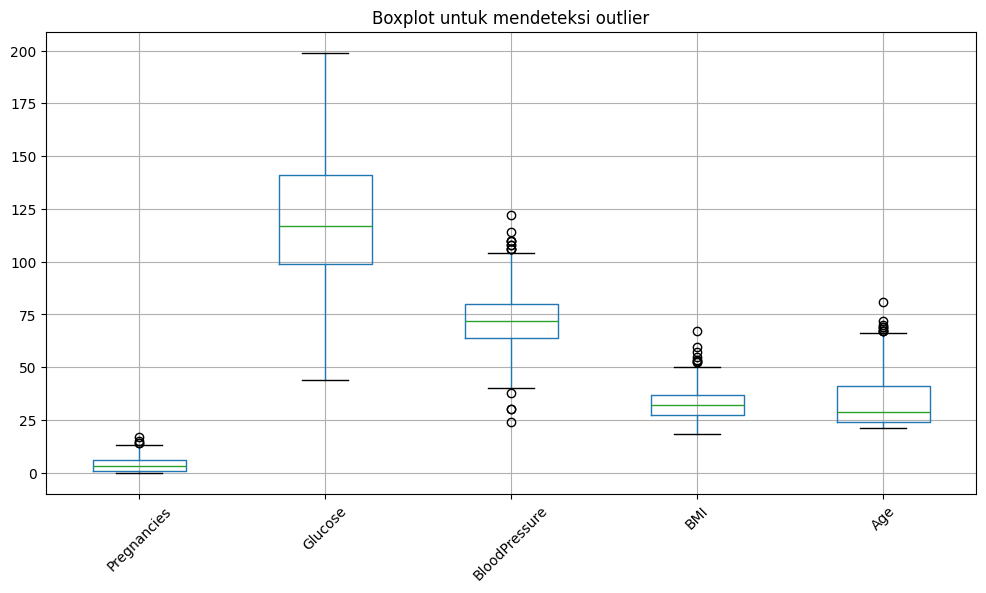

In [31]:
# Visualisasi boxplot semua fitur numerik
plt.figure(figsize=(12,6))
data.drop('Outcome', axis=1).boxplot()
plt.title("Boxplot untuk mendeteksi outlier")
plt.xticks(rotation=45)
plt.show()

In [32]:
def winsorize_outliers(df, cols, lower_percentile=0.05, upper_percentile=0.95):
    for col in cols:
        lower_bound = df[col].quantile(lower_percentile)
        upper_bound = df[col].quantile(upper_percentile)
        df[col] = np.where(df[col] < lower_bound, lower_bound, df[col])
        df[col] = np.where(df[col] > upper_bound, upper_bound, df[col])
    return df

numerical_cols = [col for col in data.select_dtypes(include=['float64', 'int64']).columns 
                  if col not in ['Outcome', 'BMI_Category']]
data = winsorize_outliers(data, numerical_cols)
print("Shape data setelah winsorizing:", data.shape)

Shape data setelah winsorizing: (768, 6)


# 5. Data Transformation

5.1 Persiapan Data

In [33]:
X = data.drop(['Outcome'], axis=1)
y = data['Outcome']

In [34]:
# Visualisasi distribusi target awal
print("Distribusi kelas awal:")
print(y.value_counts())

Distribusi kelas awal:
Outcome
0    500
1    268
Name: count, dtype: int64


In [35]:
# 2. Pemisahan data menjadi train dan test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [36]:
# Melihat distribusi kelas pada data training
print("\nDistribusi kelas pada data training:")
print(pd.Series(y_train).value_counts())


Distribusi kelas pada data training:
Outcome
0    401
1    213
Name: count, dtype: int64


In [37]:
# 3. Normalisasi data
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
# Fitting scaler HANYA pada data training
X_train_scaled = scaler.fit_transform(X_train)
# Transform data test menggunakan parameter yang sama
X_test_scaled = scaler.transform(X_test)

In [38]:
# 4. SMOTE pada data training SETELAH train-test split
from imblearn.over_sampling import SMOTE
from collections import Counter
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_scaled, y_train)

print("\nDistribusi kelas setelah SMOTE (hanya pada data training):")
print(sorted(Counter(y_train_resampled).items()))


Distribusi kelas setelah SMOTE (hanya pada data training):
[(0, 401), (1, 401)]


C:\Users\Mega Global\AppData\Local\Temp\ipykernel_11340\3468694882.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  a = sns.countplot(x='Outcome', data=data, palette='Set2', ax=ax[0])
C:\Users\Mega Global\AppData\Local\Temp\ipykernel_11340\3468694882.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  a = sns.countplot(x=y_series, palette='Set2', ax=ax[1])


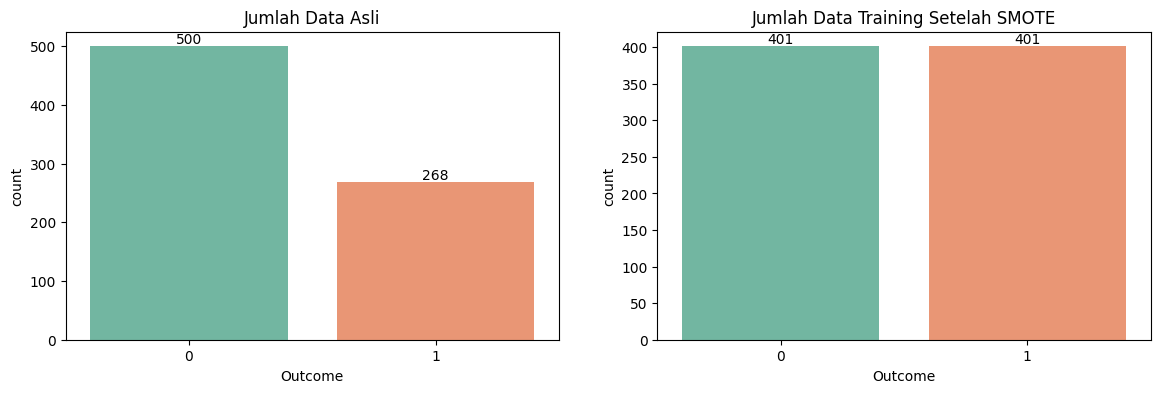

In [39]:
fig, ax = plt.subplots(1, 2, figsize=(14, 4))
# Data asli
a = sns.countplot(x='Outcome', data=data, palette='Set2', ax=ax[0])
for j in a.containers:
    a.bar_label(j, label_type='edge')
ax[0].set_title('Jumlah Data Asli')

# Data training setelah SMOTE
y_series = pd.Series(y_train_resampled, name='Outcome')
a = sns.countplot(x=y_series, palette='Set2', ax=ax[1])
for j in a.containers:
    a.bar_label(j, label_type='edge')
ax[1].set_title('Jumlah Data Training Setelah SMOTE')
plt.show()

In [40]:
# Informasi ukuran data
print('\nTotal data asli X:', len(X))
print('Total data asli y:', len(y))
print('=====================================')
print('Total data X_train awal:', len(X_train))
print('Total data y_train awal:', len(y_train))
print('Total data X_train setelah SMOTE:', len(X_train_resampled))
print('Total data y_train setelah SMOTE:', len(y_train_resampled))
print('=====================================')
print('Total data X_test:', len(X_test))
print('Total data y_test:', len(y_test))


Total data asli X: 768
Total data asli y: 768
Total data X_train awal: 614
Total data y_train awal: 614
Total data X_train setelah SMOTE: 802
Total data y_train setelah SMOTE: 802
Total data X_test: 154
Total data y_test: 154


In [41]:
models = {
    "Logistic Regression": LogisticRegression(random_state=42, solver='liblinear'),
    "SVM": SVC(kernel='linear', random_state=42),
    "Decision Tree": DecisionTreeClassifier(random_state=42),
    "Random Forest": RandomForestClassifier(random_state=42),
    "AdaBoost": AdaBoostClassifier(random_state=42),
    "Gaussian Naive Bayes": GaussianNB()
}

results = {}
for name, model in models.items():
    # Training menggunakan data training yang sudah di-SMOTE
    model.fit(X_train_resampled, y_train_resampled)
    # Evaluasi menggunakan data testing yang HANYA di-scaled (tanpa SMOTE)
    y_pred = model.predict(X_test_scaled)
    accuracy = accuracy_score(y_test, y_pred)
    results[name] = accuracy

print("\nHasil Evaluasi Model:")
for name, accuracy in results.items():
    print(f"{name}: Accuracy = {accuracy:.4f}")

best_model_name = max(results, key=results.get)
print(f"\nModel Terbaik Berdasarkan Akurasi: {best_model_name} (Accuracy = {results[best_model_name]:.4f})")


Hasil Evaluasi Model:
Logistic Regression: Accuracy = 0.7013
SVM: Accuracy = 0.7143
Decision Tree: Accuracy = 0.6948
Random Forest: Accuracy = 0.7338
AdaBoost: Accuracy = 0.7143
Gaussian Naive Bayes: Accuracy = 0.7273

Model Terbaik Berdasarkan Akurasi: Random Forest (Accuracy = 0.7338)


In [42]:
# 6. Hyperparameter tuning untuk model terbaik
from sklearn.model_selection import GridSearchCV

# Tuning hyperparameter untuk Random Forest
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [5, 10, 15, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2'],
    'class_weight': [None, 'balanced']
}

grid_search = GridSearchCV(
    RandomForestClassifier(random_state=42),
    param_grid,
    cv=5,
    scoring='accuracy',
    n_jobs=-1,
    verbose=1
)

In [43]:
# GridSearchCV pada data training yang sudah di-SMOTE
grid_search.fit(X_train_resampled, y_train_resampled)
print("\nBest Parameters:", grid_search.best_params_)
print("Best CV Score:", grid_search.best_score_)

# Mengambil model terbaik dari hasil grid search
best_rf = grid_search.best_estimator_

Fitting 5 folds for each of 432 candidates, totalling 2160 fits

Best Parameters: {'class_weight': 'balanced', 'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 300}
Best CV Score: 0.8280357142857143


In [44]:
best_rf.fit(X_train_resampled, y_train_resampled)

RandomForestClassifier(class_weight='balanced', n_estimators=300,
                       random_state=42)

In [45]:
# 7. Final evaluation dengan model terbaik
y_test_pred = best_rf.predict(X_test_scaled)  # Prediksi pada data test yang hanya di-scale
y_train_pred = best_rf.predict(X_train_resampled)  # Prediksi pada data training yang di-SMOTE

print("\nFinal Evaluation:")
print(f"Training Accuracy: {accuracy_score(y_train_resampled, y_train_pred):.4f}")
print(f"Testing Accuracy: {accuracy_score(y_test, y_test_pred):.4f}")
print("\nClassification Report (Test Data):")
print(classification_report(y_test, y_test_pred))
print("\nConfusion Matrix (Test Data):")
print(confusion_matrix(y_test, y_test_pred))



Final Evaluation:
Training Accuracy: 1.0000
Testing Accuracy: 0.7597

Classification Report (Test Data):
              precision    recall  f1-score   support

           0       0.85      0.76      0.80        99
           1       0.64      0.76      0.69        55

    accuracy                           0.76       154
   macro avg       0.74      0.76      0.75       154
weighted avg       0.78      0.76      0.76       154


Confusion Matrix (Test Data):
[[75 24]
 [13 42]]


In [46]:
# 8. Evaluasi tambahan untuk imbalanced data
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score, precision_recall_curve, auc
if hasattr(best_rf, "predict_proba"):
    y_prob = best_rf.predict_proba(X_test_scaled)[:, 1]
    roc_auc = roc_auc_score(y_test, y_prob)
    print(f"\nROC AUC Score: {roc_auc:.4f}")


ROC AUC Score: 0.8233


In [47]:
# Simpan model dan scaler
joblib.dump(scaler, 'scaler.pkl')
joblib.dump(best_rf, 'best_random_forest_model.pkl')

['best_random_forest_model.pkl']

In [48]:
# Load model dan scaler
classifier = joblib.load('best_random_forest_model.pkl')
scaler = joblib.load('scaler.pkl')

# Data input pasien
input_data = (6, 148, 72, 33.6, 50)
feature_names = ['Pregnancies', 'Glucose', 'BloodPressure', 'BMI', 'Age']

# Buat DataFrame agar sesuai dengan fitur saat scaler dilatih
input_df = pd.DataFrame([input_data], columns=feature_names)

# Scaling dan prediksi
input_scaled = scaler.transform(input_df)
prediction = classifier.predict(input_scaled)

print(f"Prediksi: {prediction[0]}")

if prediction[0] == 0:
    print('✅ Pasien tidak terkena diabetes')
else:
    print('⚠️ Pasien terkena diabetes')

Prediksi: 1
⚠️ Pasien terkena diabetes


In [49]:
# Data input pasien
input_data = (1, 85, 66, 26.6, 30)  
feature_names = ['Pregnancies', 'Glucose', 'BloodPressure', 'BMI', 'Age']

# Buat DataFrame agar sesuai dengan fitur saat scaler dilatih
input_df = pd.DataFrame([input_data], columns=feature_names)

# Scaling dan prediksi
input_scaled = scaler.transform(input_df)
prediction = classifier.predict(input_scaled)

# Output prediksi
print(f"Prediksi: {prediction[0]}")

if prediction[0] == 0:
    print('✅ Pasien tidak terkena diabetes')
else:
    print('⚠️ Pasien terkena diabetes')

Prediksi: 0
✅ Pasien tidak terkena diabetes
